## Orphan molecule formation via barcode errors

For an orphan molecule (CB, UMI, gene), we find all molecules aligning to the **same gene** 
within a given barcode distance, and make a histogram of their family sizes.

If the FSD of parents has significantly fewer orphan molecules, that that is an evidence for the presence of uncorrected barcode error.

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import editdistance
import pandas as pd
import itertools
import operator
from bisect import bisect_left, bisect_right
from commons import *

leven = editdistance.bycython.eval

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [2]:
# select dataset
mol_h5_path = '/Users/mehrtash/Data/10x/pbmc4k_molecule_info.h5'
genes_tsv_path = None

In [3]:
mol_info = MoleculeInfo(mol_h5_path, genes_tsv_path)

In [4]:
# select a range of barcodes
min_umi_count = 1000
max_umi_count = 50000
test_barcode_set = {barcode for barcode, total_umi in mol_info.total_umi_per_barcode.items()
                    if min_umi_count <= total_umi <= max_umi_count}
print(f'Selected {len(test_barcode_set)} barcodes in range ({min_umi_count}, {max_umi_count})')

# obtain full UMI count statistics
full_count_stats = get_full_umi_count_statistics(
    test_barcode_set, mol_info.gene_array, mol_info.reads_array, mol_info.barcode_array)

gene_index_sorted_by_expression = get_gene_index_sorted_by_expression(full_count_stats)
gene_index_sorted_by_expression.remove(mol_info.unmappable_gene_idx)

Selected 4481 barcodes in range (1000, 50000)


## Helper Methods

In [124]:
def generate_encoded_power_set(encoded_barcode,
                               encoded_umi,
                               max_hamming_distance=1,
                               include_indel=True,
                               remove_self=False,
                               only_umi=True):
    decoded_barcode = decode(encoded_barcode, length=16)
    decoded_umi = decode(encoded_umi, length=10)
    if not only_umi:
        total_barcode = decoded_barcode + decoded_umi
        decoded_power_set = generate_power_set(total_barcode, max_hamming_distance, include_indel, remove_self)
        return set((encode(mutated[:16]), encode(mutated[16:])) for mutated in decoded_power_set)
    else:
        decoded_umi_power_set = generate_power_set(decoded_umi, max_hamming_distance, include_indel, remove_self)
        return set((encoded_barcode, encode(mutated)) for mutated in decoded_umi_power_set)

In [125]:
def get_molecules_with_error(barcode, umi, max_hamming_distance=1, include_indel=True, only_umi=True):
    decoded_barcode = decode(barcode, length=16)
    decoded_umi = decode(umi, length=10)
        
    if max_hamming_distance > 0 or include_indel:
        potential_parents_set = generate_encoded_power_set(
            barcode, umi,
            max_hamming_distance=max_hamming_distance,
            include_indel=include_indel,
            remove_self=False,
            only_umi=only_umi)
    else:  # just self
        potential_parents_set = set()
        potential_parents_set.add((barcode, umi))
    
    all_indices = set()
    for (parent_barcode, parent_umi) in potential_parents_set:
        all_indices.update(get_molecules(parent_barcode, parent_umi, mol_info))
    
    return all_indices                

## Exploration

In [165]:
gene_index = gene_index_sorted_by_expression[6]

# indices of all FS=1 molecules for this gene
orphan_indices = np.where((mol_info.reads_array == 1) & (mol_info.gene_array == gene_index))[0]

In [166]:
max_mols = min(np.inf, len(orphan_indices))
random_mol_indices = np.random.choice(orphan_indices, size=max_mols, replace=False)

In [167]:
max_hamming_distance = 1
include_indel = True
only_umi = True

num_with_parents = 0
num_parent_same_barcode = 0

parent_family_sizes = []

for n, index in enumerate(random_mol_indices):
    if n % 1000 == 0:
        print(str(n) + "...")
        
    barcode = mol_info.barcode_array[index]
    umi = mol_info.umi_array[index]
    potential_parents_set = get_molecules_with_error(barcode, umi, max_hamming_distance, include_indel, only_umi)
    
    # only parents in the same gene
    final_parents_indices = [p_index for p_index in potential_parents_set
                             if p_index != index and mol_info.gene_array[p_index] == gene_index]
    
    if len(final_parents_indices) > 0:
        num_with_parents += 1
        p_index = final_parents_indices[0]
        parent_family_sizes.append(mol_info.reads_array[p_index])
        num_parent_same_barcode += (mol_info.barcode_array[p_index] == barcode)
        print((decode(barcode, 16),
               decode(umi, 10),
               decode(mol_info.barcode_array[p_index], 16),
               decode(mol_info.umi_array[p_index], 10)))

0...
('CATATTCGTATGAAAC', 'ACAACACTTA', 'CATATTCGTATGAAAC', 'ACAACCTTAA')
('TCATTTGAGAACAACT', 'GCCCATACAT', 'TCATTTGAGAACAACT', 'CCCATACATG')
('AGTGGGATCTTAACCT', 'GAGAACCTAG', 'AGTGGGATCTTAACCT', 'AGAACCTAGC')
('CTGCTGTGTTACGTCA', 'CGACGGCAGG', 'CTGCTGTGTTACGTCA', 'CGAGGCAGGC')
('ATCCGAACACACTGCG', 'TAATGCGCAC', 'ATCCGAACACACTGCG', 'TAATGCGCTA')
('GTCACGGAGCGATCCC', 'AACGGACCAT', 'GTCACGGAGCGATCCC', 'CAACGGACCA')
('ATCCGAAGTGACTCAT', 'GCGGAACTGT', 'ATCCGAAGTGACTCAT', 'GCGGCAACTG')
1000...
('TACAGTGAGTACGCCC', 'AGATCGCCAT', 'TACAGTGAGTACGCCC', 'AAGATCGCCA')
('TTCCCAGGTTATCGGT', 'CTAAGAACAA', 'TTCCCAGGTTATCGGT', 'CTAAAGAACA')
('AACTCTTGTTACGCGC', 'TATTGGATAT', 'AACTCTTGTTACGCGC', 'TATTGGTATA')
('ACTGAGTCATCCCATC', 'GCGGCAGCAC', 'ACTGAGTCATCCCATC', 'GCGGCAGCCG')
('AGCAGCCCAGATAATG', 'TCGCCGGGGG', 'AGCAGCCCAGATAATG', 'TCGCGGGGGT')
2000...
('GTGCTTCGTTCCCTTG', 'CACGTGCAAA', 'GTGCTTCGTTCCCTTG', 'CACGTGACAA')
('CGATCGGCACGTAAGG', 'AGCCAATTTT', 'CGATCGGCACGTAAGG', 'GAGCCAATTT')
('AGGTCCGTCGG

In [168]:
def plot_umi_hist_for_gene(ax,
                           gene_idx: int,
                           gene_names_array: np.ndarray,
                           full_count_stats: Dict,
                           min_family_size_frac: int=1,
                           min_family_size_plot: int=0,
                           decode_gene_ascii: bool=True,
                           max_family_size_plot: int=60,
                           hist_bins: int=20):
    family_size_list = full_count_stats[gene_idx]
    family_size_list_for_plotting = [x for x in family_size_list if x > min_family_size_plot]

    gene_name_ascii = (gene_names_array[gene_idx].decode('ascii')
                       if decode_gene_ascii else gene_names_array[gene_idx])
    _ = ax.hist(family_size_list_for_plotting,
        bins=hist_bins,
        range=(0,max_family_size_plot),
                log=False, normed=True, label=gene_name_ascii)
    ax.legend(fontsize=12)
    ax.set_ylabel(r'$P(FS)$', fontsize=18)
    ax.set_xlabel(r'$FS$', fontsize=18)
    
    lte_min_family_size = sum(
        1 for family_size in family_size_list if family_size <= min_family_size_frac)
    all_observations = len(family_size_list)
    
    print(f'Observations with family size <= {min_family_size_frac} '
          f'for gene {gene_name_ascii}: {100*float(lte_min_family_size/all_observations):.1f}%')

Observations with family size <= 1 for gene RPL41: 21.8%


Text(0.5,1,'Rescue Rate: 0.004')

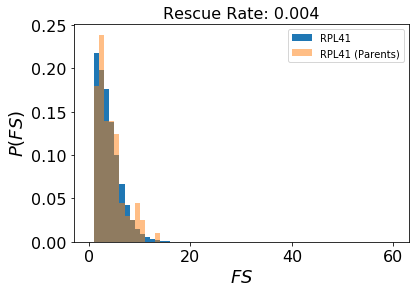

In [173]:
fig = plt.figure()
ax = plt.gca()

plot_umi_hist_for_gene(ax, gene_index, mol_info.gene_names_array, full_count_stats, hist_bins=60)
plt.hist(parent_family_sizes,
         alpha=0.5,
         bins=60,
         range=(0, 60),
         density=True,
         label=mol_info.gene_names_array[gene_index].decode('ascii') + ' (Parents)')
plt.legend()
plt.title('Rescue Rate: {0:.3f}'.format(num_with_parents / max_mols), fontsize=16)
# plt.savefig('./plots/pbmc4k_UMI_HD_2_INDEL_rescue_parents_RPL21.pdf')